In [2]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import json
import random
from scipy.stats import norm

random.seed(42)

if len(sys.argv) != 3 and 0:
    print('Usage: python autocorrelation.py <json_file> <stat>')
    sys.exit(1)

json_file = "../simulations/results/DataAnalysis.json" # sys.argv[1]
stat = "taskTimeStat:vector" #sys.argv[2]

f = open(json_file, 'r')
data = json.load(f)

print("data loaded")


data loaded


In [23]:

repetitions_original = {'0':{'true':{}, 'false':{}}, '1':{'true':{}, 'false':{}}}

for repetition in data:
    for vector in data[repetition]['vectors']:
        if vector['name'] != stat:
            continue
        
        #if data[repetition]['itervars']['distr'] != '1' or data[repetition]['itervars']['fairSharing'] != 'true':
        #    continue
        distr = data[repetition]['itervars']['distr']
        fairshare = data[repetition]['itervars']['fairSharing']
        N = int(data[repetition]['itervars']['N'])
        repetitions_original[distr][fairshare][N] = vector['value']
        break

print("repetitions loaded")


repetitions loaded


In [22]:
a = list(repetitions_original['0']['true'].keys())
a.sort()
a

['1',
 '10',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '5',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '6',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '7',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '8',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '9',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99']

In [24]:
alpha = 0.05

repetitions_sampled = {'0':{'true':{}, 'false':{}}, '1':{'true':{}, 'false':{}}}

for distr in repetitions_original:
    for fairshare in repetitions_original[distr]:
        repetitions = repetitions_original[distr][fairshare]
        p = [1.5 for i in range(len(repetitions))]
        autocorrelated = [True for i in range(len(repetitions))]
        for rep in range(100, 0, -1):
            rep_0 = rep-1

            while autocorrelated[rep_0]:
                p[rep_0] /= 1.5

                if p[rep_0] < 2**(-15):
                    exit(f"error at {rep}")

                samples = []
                for s in repetitions[rep]:
                    if random.random() < p[rep_0]:
                        samples.append(s)

                print(rep, 'p:', p[rep_0])
                print('Original samples:', len(repetitions[rep]))
                print('Samples:', len(samples))

                autocorrelation = []

                X_avg = sum(samples) / len(samples)
                S2 = sum([(x - X_avg) ** 2 for x in samples]) / (len(samples) - 1)

                for i in range(1, min(100, len(samples)//5)):
                    sum_ = 0
                    for j in range(len(samples) - i):
                        sum_ += (samples[j] - X_avg) * (samples[j + i] - X_avg)
                    autocorrelation.append(sum_ / ((len(samples) - i) * S2))

                z = norm.ppf(1 - alpha/2)
                confidence = z / (len(samples) ** 0.5)

                out_of_bounds = 0
                outliers = 0
                
                for i in range(len(autocorrelation)):
                    if abs(autocorrelation[i]) > confidence:
                        out_of_bounds += 1
                        outliers += abs(autocorrelation[i])-confidence

                if out_of_bounds < len(autocorrelation) * alpha * 1.3 and outliers < confidence:
                    autocorrelated[rep_0] = False
                    repetitions_sampled[distr][fairshare][rep] = samples

                # plot autocorrelation and confidence interval
                #plt.plot(autocorrelation)
                #plt.axhline(confidence, color='r', linestyle='dashed')
                #plt.axhline(-confidence, color='r', linestyle='dashed')
                #plt.show()

#print(autocorrelated)
#print(p)
#[print(1/p[i]) for i in range(len(p))]




100 p: 1.0
Original samples: 99600
Samples: 99600
100 p: 0.6666666666666666
Original samples: 99600
Samples: 66320
100 p: 0.4444444444444444
Original samples: 99600
Samples: 44182
100 p: 0.2962962962962963
Original samples: 99600
Samples: 29578
100 p: 0.19753086419753085
Original samples: 99600
Samples: 19504
99 p: 1.0
Original samples: 99600
Samples: 99600
99 p: 0.6666666666666666
Original samples: 99600
Samples: 66593
98 p: 1.0
Original samples: 99600
Samples: 99600
98 p: 0.6666666666666666
Original samples: 99600
Samples: 66563
98 p: 0.4444444444444444
Original samples: 99600
Samples: 44037
97 p: 1.0
Original samples: 99600
Samples: 99600
97 p: 0.6666666666666666
Original samples: 99600
Samples: 66105
96 p: 1.0
Original samples: 99600
Samples: 99600
96 p: 0.6666666666666666
Original samples: 99600
Samples: 66461
95 p: 1.0
Original samples: 99600
Samples: 99600
95 p: 0.6666666666666666
Original samples: 99600
Samples: 66312
94 p: 1.0
Original samples: 99600
Samples: 99600
94 p: 0.666

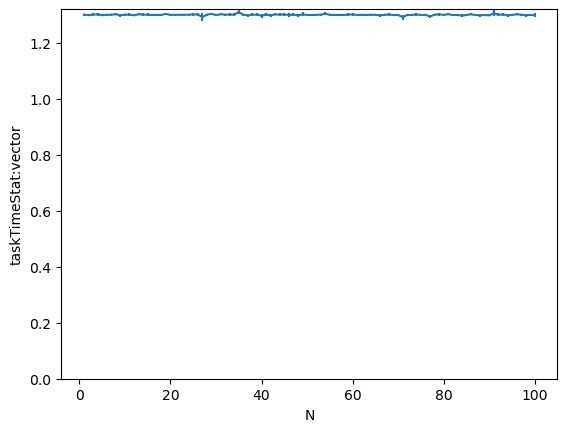

In [29]:
N = [i for i in range(1, len(repetitions_original['1']['true'])+1)]
average = []
confidence = []

alpha = 0.05
z = norm.ppf(1 - alpha/2)

repetitions = repetitions_sampled['0']['true']
for n in N:
    X = sum(repetitions[n]) / len(repetitions[n])
    S = (sum([(x - X) ** 2 for x in repetitions[n]]) / (len(repetitions[n]) - 1)) ** 0.5

    average.append(X)
    confidence.append(z * S / (len(repetitions[n]) ** 0.5))

plt.errorbar(N, average, yerr=confidence)
plt.xlabel('N')
plt.ylabel(stat)

#set y to start at 0
plt.ylim(bottom=0)
plt.show()

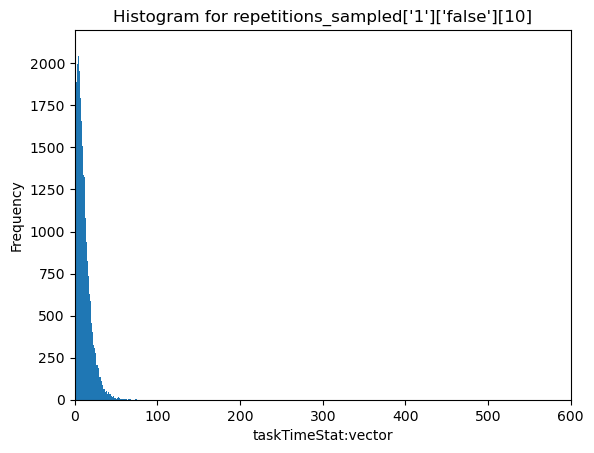

In [73]:
# Plot histogram for repetitions_sampled['1']['false'][10]
repetitions = repetitions_original['1']['false'][10]
plt.hist(repetitions, bins=300)#, edgecolor='black')
plt.xlabel(stat)
plt.ylabel('Frequency')
plt.title('Histogram for repetitions_sampled[\'1\'][\'false\'][10]')
plt.xlim(left=0, right=600)
plt.show()

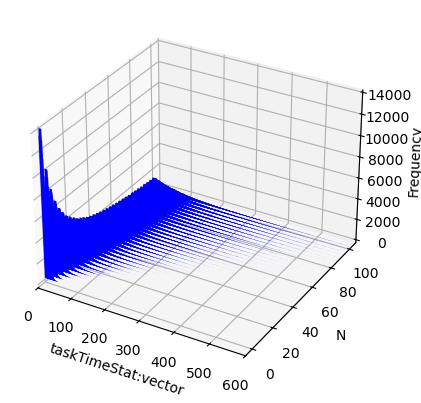

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# plot distribution of the original samples

repetitions = repetitions_original['1']['false']

# make a 3D histogram for various N
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Prepare data for 3D histogram
for n in range(1, len(repetitions)+1, 3):
    hist, bins = np.histogram(repetitions[n], bins=np.arange(0, 601, 1))
    bins = 0.5 * (bins[:-1] + bins[1:])  # Convert bin edges to centers
    ax.bar(bins, hist, zs=n, zdir='y', alpha=1, label=f'N={n}', width=8, color='b')
    # set x limits
    ax.set_xlim(0, 600)
    
ax.set_xlabel(stat)
ax.set_ylabel('N')
ax.set_zlabel('Frequency')
#plt.legend(loc='upper right')
plt.show()



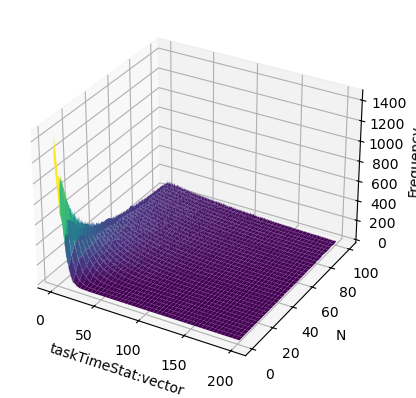

In [72]:

# Prepare data for surface plot
X, Y = np.meshgrid(np.arange(0, 201, 0.1), np.arange(1, len(repetitions)+1, 3))
Z = np.zeros_like(X, dtype=float)

for idx, n in enumerate(range(1, len(repetitions)+1, 3)):
    hist, bins = np.histogram(repetitions[n], bins=np.arange(0, 201.1, 0.1))
    Z[idx, :] = hist

# Plot surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel(stat)
ax.set_ylabel('N')
ax.set_zlabel('Frequency')
plt.show()


In [79]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Unisci tutti i dati in una singola lista
data = repetitions_original['1']['true']
all_data = []
for key in data:
    all_data.extend(data[key])

# Converti i dati in un array di NumPy
all_data = np.array(all_data)

# Lista delle distribuzioni da testare
distributions = ['t', 'expon', 'uniform', 'gamma', 'beta', 't', 'chi2']

# Crea un QQ plot per ciascuna distribuzione
for distribution in distributions:
    plt.figure()
    stats.probplot(all_data, dist=distribution, plot=plt)
    plt.title(f"QQ Plot di repetitions_original['1']['true'] con distribuzione {distribution}")
    plt.show()

TypeError: _parse_args() missing 1 required positional argument: 'df'

<Figure size 640x480 with 0 Axes>